In [176]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm
import statsmodels.tsa.stattools as sm
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import math
from sklearn.metrics import mean_squared_error
import numpy as np

In [177]:
data = pd.read_csv('data.csv', sep='\t')

In [178]:
data

,Inventory,Sales
0,100,97.0
1,97,91.0
2,91,90.0
3,90,87.0
4,87,87.0
...,...,...
11515,102,90.0
11516,92,91.0
11517,91,87.0
11518,87,85.0


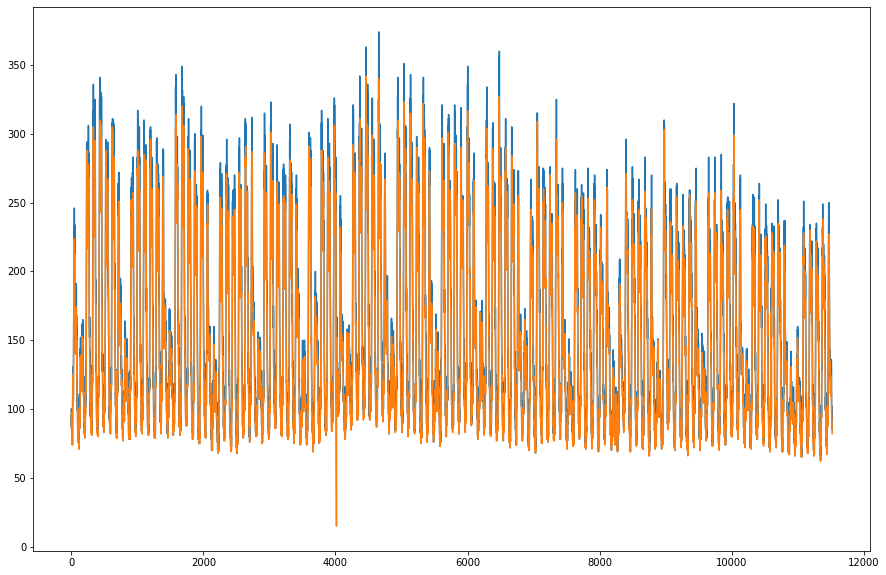

In [179]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(data);

In [216]:
past_moves = np.array(data.Inventory[:10000,]) #x_train
past_sales = np.array([int(i) for i in data.Sales[:10000,]]) #y_train
future_demand = np.array([int(i) for i in data.Sales[10000:11519,]]) #x_test

In [217]:
gain = 1
loss = 9
nmoves = 0

In [218]:
def evaluate(past_moves, past_sales, demand, gain, loss, order_fn):
    """ evaluate student's moves; parameters:
        * past_moves: history of past inventories
        * past_sales: history of past sales
        * demand: true future demand (unknown to students)
        * gain: profit per sold unit
        * loss: deficit generated per unit unsold
        * order_fn: function implementing student's method
    """
    moves = []
    def market(move):
        """ demand function ("censored", as it is limited by 'move'); parameter:
            * move: quantity available for selling (i.e., inventory)
        """
        global nmoves
        if nmoves >= len(demand):
            return None
        moves.append(move)
        sales = min(move, demand[nmoves])
        nmoves += 1
        return sales
    
    profit = 0
    n = len(demand)
    orders = []
    sales = []
    order_fn(past_moves, past_sales, market)

    for i in range(n):
        if moves[i] > demand[i]:
            profit += demand[i]*gain - (moves[i]-demand[i])*loss
        else:
            profit += moves[i]*gain
        print(f"{i+1}\t{demand[i]}\t{moves[i]}\t{moves[i]-demand[i]}\t{profit}")
    return profit

In [219]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [220]:
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [221]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [222]:
def invert_difference(history, y_hat, interval=1):
    return y_hat + history[-interval]

In [223]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, 1)
    y_hat = model.predict(X, batch_size=batch_size, verbose=0)
    return y_hat[0,0]

In [224]:
raw_sales = past_sales

In [225]:
raw_moves = past_moves

In [226]:
diff_sales = difference(raw_sales, 1)

In [227]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_sales, 1)

In [228]:
supervised_values = supervised.values

In [229]:
len(supervised_values)

9999

In [230]:
# spliting in train and test
train_size = len(past_sales)

In [231]:
train, test = supervised_values, future_demand

In [232]:
def order(past_moves, past_sales, market):
    """ function implementing a simple strategy; parameters:
        * past_sales: list with historical data for the market trend
        * market: function to evaluate the actual sales; 'market(value)' returns:
                - inventory, if smaller than demand (everything was sold)
                - true demand otherwise (i.e., some inventory wasn't sold)
    """

    #training 
    lstm_model = fit_lstm(train, 1, 30, 4)
    # predicting the test case
    for i in range(len(test)):
        # make one-step forecast
        X = test[i]
        y_hat = forecast_lstm(lstm_model, 1, X)
        # invert the differencing previously done 
        y_hat = invert_difference(raw_sales, y_hat, len(test)+1-i)
        # store forecast
        pred = round(y_hat)
        # report performance
        sold = market(pred)
        if sold == None:
            return 

In [233]:
nmoves = 0
profit = evaluate(past_moves, past_sales, future_demand, gain, loss, order)

1	82	118.0	36.0	-242.0
2	80	118.0	38.0	-504.0
3	80	129.0	49.0	-865.0
4	88	141.0	53.0	-1254.0
5	97	155.0	58.0	-1679.0
6	94	170.0	76.0	-2269.0
7	88	186.0	98.0	-3063.0
8	88	204.0	116.0	-4019.0
9	86	222.0	136.0	-5157.0
10	87	222.0	135.0	-6285.0
11	96	224.0	128.0	-7341.0
12	106	213.0	107.0	-8198.0
13	111	213.0	102.0	-9005.0
14	105	234.0	129.0	-10061.0
15	105	257.0	152.0	-11324.0
16	107	258.0	151.0	-12576.0
17	107	257.0	150.0	-13819.0
18	118	250.0	132.0	-14889.0
19	130	250.0	120.0	-15839.0
20	143	231.0	88.0	-16488.0
21	157	223.0	66.0	-16925.0
22	173	211.0	38.0	-17094.0
23	190	211.0	21.0	-17093.0
24	209	213.0	4.0	-16920.0
25	230	212.0	-18.0	-16708.0
26	253	212.0	-41.0	-16496.0
27	244	219.0	-25.0	-16277.0
28	249	219.0	-30.0	-16058.0
29	249	214.0	-35.0	-15844.0
30	266	214.0	-52.0	-15630.0
31	266	214.0	-52.0	-15416.0
32	293	224.0	-69.0	-15192.0
33	299	217.0	-82.0	-14975.0
34	275	215.0	-60.0	-14760.0
35	268	215.0	-53.0	-14545.0
36	249	226.0	-23.0	-14319.0
37	228	226.0	-2.0	-14093.0
38	226	226.0	0